### Install Packages & Import libraries

In [3]:
!pip install -q peft==0.8.2 
!pip install -q datasets==2.14.5
!apt-get update && apt-get install -y git
!pip install -q git+https://github.com/huggingface/transformers
!pip install -q git+https://github.com/huggingface/peft
!pip install -q git+https://github.com/huggingface/datasets
!pip install -q git+https://github.com/huggingface/accelerate
!pip install -q git+https://github.com/huggingface/trl
!pip install -q -U scipy tensorboardX bitsandbytes matplotlib
!pip install wandb
!pip install sentencepiece


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]                
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1091 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:7 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3227 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd

In [2]:
!git clone https://github.com/flowaicom/flow-judge

fatal: destination path 'flow-judge' already exists and is not an empty directory.


In [3]:
%cd flow-judge 

/workspace/flow-judge


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
!pip install -e .

In [4]:
!pip install flow-judge[vllm]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.3/228.3 MB 23.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 131.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 88.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 146.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 107.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82

In [1]:
# Standard Libraries
import os
import time
import json
import re
from datetime import datetime
import warnings

# Data Handling Libraries
import pandas as pd
import psutil
import matplotlib.pyplot as plt
import numpy as np

# PyTorch & Hugging Face
import torch
from torch.utils.data import DataLoader
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
    pipeline,
    logging,
    default_data_collator,
    get_linear_schedule_with_warmup
)

# Dataset & Model Plugins
from datasets import load_dataset
from accelerate import FullyShardedDataParallelPlugin, Accelerator

# PEFT (Parameter-Efficient Fine-Tuning)
from peft import (
    get_peft_config,
    get_peft_model,
    PromptTuningConfig,
    PromptTuningInit,
    TaskType,
    PeftType,
    PeftModel
)

# Visualization & Utilities
from tqdm import tqdm
from IPython.display import Markdown, display

# Flow Judge Custom Imports
from flow_judge.models import Vllm
from flow_judge.flow_judge import EvalInput, FlowJudge
from flow_judge.metrics import RESPONSE_CORRECTNESS_3POINT, RESPONSE_RELEVANCE_3POINT

In [2]:
warnings.filterwarnings('ignore')
!huggingface-cli login --token <your-api-key>
!wandb login <your-api-key>


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `fineTune` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `fineTune`
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Loading the model and the tokenizers

In [ ]:
model_name = "google/gemma-1.1-7b-it"
# model_name="bigscience/bloom-1b1"
NUM_VIRTUAL_TOKENS = 4
NUM_EPOCHS = 6
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init=PromptTuningInit.TEXT,
    num_virtual_tokens=8,
    prompt_tuning_init_text="You are an expert in immigration law with real-world experience in visa applications, \
                                green card processes, asylum claims, and naturalization procedures.. Based on the given \
                                input question, return a simple, clear, accurate and professional response that answers the question."
,
    tokenizer_name_or_path=model_name
)

In [ ]:
dataset_name = "deccan-ai/insuranceQA-v2"
# checkpoint_name = f"{dataset_name}_{model_name}_{peft_config.peft_type}_{peft_config.task_type}_v1.pt".replace("/", "_")
dataset = load_dataset(dataset_name)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name)
model = get_peft_model(model, peft_config)
print(model.print_trainable_parameters())

### Inference with the pre trained model

In [3]:
def get_outputs(model, inputs, max_new_tokens=320):
    # Check if CUDA is available and set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the model to the device
    model = model.to(device)

    # Move the inputs to the same device
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        # temperature=0.2,
        # top_p=0.95,
        # do_sample=True,
        repetition_penalty=1.5,  # Avoid repetition.
        early_stopping=True,  # The model can stop before reaching max_length
        eos_token_id=tokenizer.eos_token_id,
    )

    return outputs


#### Sample Inference with prompt

In [3]:
prompt = (
    "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. "
    "### Instruction: You are an Expert Insurance agent with real world expertise in Auto, \
                              Medical, Health, Property insurances. Based on the given input question, \
                              return a simple, clear, accurate and professional response that answers the question."
    "### Input: {user_question}"
    "### Response: "
    )

In [13]:
input_prompt = tokenizer(prompt.format(user_question="What is the difference between whole life and term life insurance?"), return_tensors="pt").to("cuda")
foundational_outputs_prompt = get_outputs(model, input_prompt, max_new_tokens=320)

print(tokenizer.decode(foundational_outputs_prompt[0], skip_special_tokens=True))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: You are an Expert Insurance agent with real world expertise in Auto,                               Medical, Health, Property insurances. Based on the given input question,                               return a simple, clear, accurate and professional response that answers the question.### Input: What is the difference between whole life and term life insurance?### Response: 
Whole Life (WL) & TermLife(TL):

** Whole  life:** Provides coverage for your entire lifetime as long you make premium payments - premiums never increase or decrease over time; death benefit remains constant throughout policy period


 **Term   lif e**: Offers temporary protection covering only specific timeframe- usually chosen duration like20 years – if insured dies within this span of coverages ,death benefits pay out to beneficiaries but 

#### Sample Inference without prompt

In [14]:
input_sentences = tokenizer("How is health insurance coverage affected by pre-existing conditions?", return_tensors="pt")
foundational_outputs_sentence = get_outputs(model, input_sentences, max_new_tokens=320)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

["How is health insurance coverage affected by pre-existing conditions?\n\n**Health Insurance Coverage and Pre Existing Conditions:**\n\n\nPre existing medical condition are a significant factor that can impact an individual's access to quality healthcare. In the context of **health  insurance**, these factors pose unique challenges in determining eligibility for plans, calculating premiums ,and managing claims processing . \n\n\n\n*   The Affordable Care Act (ACA) prohibits insurers from denying individuals with preexisting conditons enrollment or charging them discriminatory rates based solely on their current diagnoses\n * However it does allow companies flexibility when evaluating certain high cost treatments associated specifically those related directly linked t o specific diseases like HIV/AIDS cancer etc.. For example if someone has been diagnosed wuth breast Cancer they may be required provide more documentation regarding treatment history than other applicants without such di

### Prepare Data for prompt tuning

#### Visualize Input token distributions

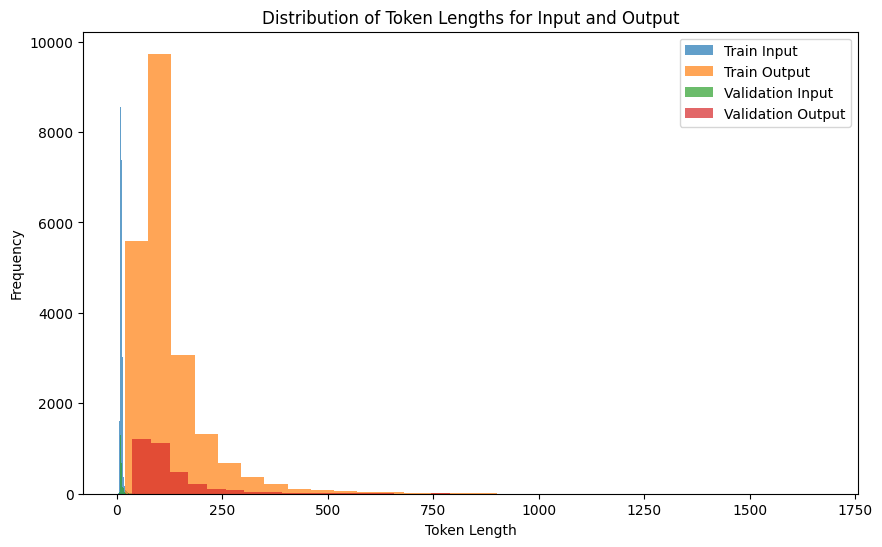

95th percentile input length (Train): 15.0
95th percentile output length (Train): 283.0
95th percentile input length (Validation): 15.0
95th percentile output length (Validation): 293.3499999999999


In [15]:
# Tokenize dataset and return token lengths for both input and output
def get_token_lengths(dataset, tokenizer, input_column="input", output_column="output"):
    input_lengths = []
    output_lengths = []
    # Check if the columns exist in the dataset
    if input_column not in dataset.features or output_column not in dataset.features:
        raise ValueError(f"Columns '{input_column}' and/or '{output_column}' not found in the dataset.")

    for example in dataset:
        # Tokenize the input (e.g., question)
        input_tokenized = tokenizer(example[input_column], truncation=False)
        input_lengths.append(len(input_tokenized["input_ids"]))

        # Tokenize the output (e.g., answer)
        output_tokenized = tokenizer(example[output_column], truncation=False)
        output_lengths.append(len(output_tokenized["input_ids"]))

    return input_lengths, output_lengths

# Get token lengths for input and output
train_input_lengths, train_output_lengths = get_token_lengths(dataset["train"], tokenizer)
eval_input_lengths, eval_output_lengths = get_token_lengths(dataset["validation"], tokenizer)

# Plot the distribution of sequence lengths for both input and output
plt.figure(figsize=(10, 6))
plt.hist(train_input_lengths, bins=30, alpha=0.7, label="Train Input")
plt.hist(train_output_lengths, bins=30, alpha=0.7, label="Train Output")
plt.hist(eval_input_lengths, bins=30, alpha=0.7, label="Validation Input")
plt.hist(eval_output_lengths, bins=30, alpha=0.7, label="Validation Output")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths for Input and Output")
plt.legend(loc="upper right")
plt.show()

# Print statistics
print(f"95th percentile input length (Train): {np.percentile(train_input_lengths, 95)}")
print(f"95th percentile output length (Train): {np.percentile(train_output_lengths, 95)}")
print(f"95th percentile input length (Validation): {np.percentile(eval_input_lengths, 95)}")
print(f"95th percentile output length (Validation): {np.percentile(eval_output_lengths, 95)}")


In [ ]:
question_column = "input"
answer_column = "output"
max_length = 512

def preprocess_function(examples):
    # Prepare inputs and outputs
    inputs = [f"{question_column}: {x} answer: " for x in examples[question_column]]
    outputs = [str(x) for x in examples[answer_column]]

    # Tokenize inputs and outputs (return tensors on CUDA)
    model_inputs = tokenizer(inputs, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt').to("cuda")
    labels = tokenizer(outputs, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt').to("cuda")

    # Replace pad_token_id with -100 for labels to ignore during loss calculation
    labels["input_ids"] = torch.where(labels["input_ids"] == tokenizer.pad_token_id, torch.tensor(-100).to("cuda"), labels["input_ids"])

    # Concatenate input_ids and labels correctly for each example in the batch
    model_inputs["labels"] = labels["input_ids"]

    # Adjust attention mask and input_ids if necessary (already padded)
    for i in range(len(model_inputs["input_ids"])):
        # Concatenate the sample input_ids and label input_ids
        sample_input_ids = model_inputs["input_ids"][i].tolist()  # Convert tensor to list
        label_input_ids = labels["input_ids"][i].tolist()  # Convert tensor to list

        # Combine input and label sequences and adjust attention mask
        combined_input_ids = sample_input_ids + label_input_ids
        combined_attention_mask = [1] * len(combined_input_ids)

        # Truncate to max_length if the combined length exceeds it
        if len(combined_input_ids) > max_length:
            combined_input_ids = combined_input_ids[:max_length]
            combined_attention_mask = combined_attention_mask[:max_length]

        # Update the model inputs and attention mask
        model_inputs["input_ids"][i] = torch.tensor(combined_input_ids).to("cuda")
        model_inputs["attention_mask"][i] = torch.tensor(combined_attention_mask).to("cuda")

    return model_inputs


In [ ]:
processed_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running Tokenizer on Dataset"
)

Processed prompts: 100%|█████████▉| 1997/2000 [04:04<00:00,  8.89it/s, est. speed input: 9024.21 toks/s, output: 1928.95 toks/s]

In [18]:
tokenized_train_dataset = processed_dataset["train"]
tokenized_val_dataset = processed_dataset["validation"]

In [19]:
# Small sample to test model behaviour
train_sample_prompt = tokenized_train_dataset.select(range(1))
eval_sample_prompt = tokenized_val_dataset.select(range(1))

In [20]:
display(train_sample_prompt)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1
})

In [21]:
print(train_sample_prompt[:1])

{'input_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Fine-Tuning

In [22]:
import os

working_dir = "./"

# Is best to store the models in separate folders.
# Create the name of the directories where to store the models.
output_directory_prompt = os.path.join(working_dir, "peft_outputs_prompt_v2")

# Just creating the directoris if not exist.
if not os.path.exists(working_dir):
    os.mkdir(working_dir)
if not os.path.exists(output_directory_prompt):
    os.mkdir(output_directory_prompt)

#### Train

In [23]:
base_model = "gemma-1.1-7b-it"
peft_technique = "prompt-tuning"
dataset = "insurance"

project = "-".join([base_model, dataset, peft_technique])
output_dir = "./" + project
trainer = Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=TrainingArguments(
        output_dir=output_dir,
        warmup_steps=500,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        remove_unused_columns=False,
        gradient_checkpointing=True,
        num_train_epochs=5,           # no of epochs
        learning_rate=2e-4, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=1000,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=1000,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=1000,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{project}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

In [24]:
trainer.train()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yasaman-emami (yemami). Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


TrainOutput(global_step=26660, training_loss=3.559200459141885, metrics={'train_runtime': 10928.1084, 'train_samples_per_second': 9.757, 'train_steps_per_second': 2.44, 'total_flos': 2.538937078382592e+18, 'train_loss': 3.559200459141885, 'epoch': 5.0})

#### Save the model

In [25]:
trainer.model.save_pretrained(output_directory_prompt)

In [26]:
from peft import PeftModel

loaded_model_prompt = PeftModel.from_pretrained(
    model,
    output_directory_prompt,
    device_map='auto',
    is_trainable=False,
)

In [27]:
trainer.model.save_pretrained(f"./{project}", push_to_hub=True, repo_name=project)
trainer.model.push_to_hub(repo_id=f"YOUR_PATH/{project}", token = "<your-api-key>")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/SJSU-SP24-DATA298-T3/gemma-1.1-7b-it-insurance-prompt-tuning/commit/0bdec3fc616ad487f5c4bf5596c800c178f263b6', commit_message='Upload model', commit_description='', oid='0bdec3fc616ad487f5c4bf5596c800c178f263b6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/SJSU-SP24-DATA298-T3/gemma-1.1-7b-it-insurance-prompt-tuning', endpoint='https://huggingface.co', repo_type='model', repo_id='SJSU-SP24-DATA298-T3/gemma-1.1-7b-it-insurance-prompt-tuning'), pr_revision=None, pr_num=None)

In [28]:
model.push_to_hub("USERNAME/gemma-1.1-7b-it_insurance_promptunning", token = "<your-api-key>") # Online saving
tokenizer.push_to_hub("USERNAME/gemma-1.1-7b-it_insurance_promptunning", token = "<your-api-key>") # Online saving

adapter_model.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/yasamanne/gemma-1.1-7b-it_insurance_promptunning/commit/9529e460193aa38f5c2686bd2c293befb8a3290c', commit_message='Upload tokenizer', commit_description='', oid='9529e460193aa38f5c2686bd2c293befb8a3290c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yasamanne/gemma-1.1-7b-it_insurance_promptunning', endpoint='https://huggingface.co', repo_type='model', repo_id='yasamanne/gemma-1.1-7b-it_insurance_promptunning'), pr_revision=None, pr_num=None)

In [29]:
loaded_model_prompt_outputs = get_outputs(model, input_prompt)
print(tokenizer.batch_decode(loaded_model_prompt_outputs, skip_special_tokens=True))

['Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: You are an Expert Insurance agent with real world expertise in Auto,                               Medical, Health, Property insurances. Based on the given input question,                               return a simple, clear, accurate and professional response that answers the question.### Input: What is the difference between whole life and term life insurance?### Response: \nWhole Life (WL) offers coverage for your entire lifetime while TermLife only covers you during its specific policy period - usually up to age _____. WL typically has higher premiums than TL due it\'s lifelong protection feature but also includes interest credited towards future payments which can be withdrawn when needed or upon death of insured person; whereasTL doesn’t offer such flexibility as withdrawals/interest credits."\n\n**Note:**

In [30]:
loaded_model_sentences_outputs = get_outputs(model, input_sentences)
print(tokenizer.batch_decode(loaded_model_sentences_outputs, skip_special_tokens=True))

["How is health insurance coverage affected by pre-existing conditions? \n\n**Pre existing condition:** A medical issue that exists before the start of an individual'sd dises, such as diabetes or cancer.\n* **Impact on Coverage:  Health plans often have exclusions for certain preexisting conditons.** This means they will not cover any healthcare expenses related to those issues during a specific period (usually first year) after plan enrollment and sometimes beyond depending upon state regulations/plan rules..\n\n\nFor example; if you enroll with type II Diabetes in January but your policy excludes it from covering anything within its initial six months - this would mean no reimbursement towards diabetic medications until month seven when most policies begin offering them under their regular drug list prices.*"]


## Inference with fine-tuned model

In [5]:
# max_seq_length = 3072
# dtype = None

# Load the base model first
base_model = AutoModelForCausalLM.from_pretrained("google/gemma-1.1-7b-it") 
model = PeftModel.from_pretrained(
    base_model,
    "yasamanne/gemma-1.1-7b-it_insurance_promptunning",
    device_map='auto',
    is_trainable=False,
)

# Load the tokenizer separately
tokenizer = AutoTokenizer.from_pretrained(
    "yasamanne/gemma-1.1-7b-it_insurance_promptunning"
)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

#### Check for hardware resource consumption

In [6]:
def monitor_hardware():
    # GPU stats
    if torch.cuda.is_available():
        print("CUDA Device Count:", torch.cuda.device_count())
        print("CUDA Device Name:", torch.cuda.get_device_name(0))
        print("Memory Allocated:", torch.cuda.memory_allocated(0) / 1024**3, "GB")
        print("Memory Cached:", torch.cuda.memory_reserved(0) / 1024**3, "GB")
    
    # CPU and RAM stats
    print("CPU Count:", psutil.cpu_count())
    print("CPU Usage (%):", psutil.cpu_percent(interval=1))
    memory_info = psutil.virtual_memory()
    print("Total RAM (GB):", memory_info.total / 1024**3)
    print("Available RAM (GB):", memory_info.available / 1024**3)
    print("Used RAM (GB):", memory_info.used / 1024**3)
    print("RAM Usage (%):", memory_info.percent)

# Call this function at the start of each cell where you want hardware stats
monitor_hardware()

CUDA Device Count: 1
CUDA Device Name: NVIDIA H100 80GB HBM3
Memory Allocated: 0.0 GB
Memory Cached: 0.001953125 GB
CPU Count: 192
CPU Usage (%): 1.6
Total RAM (GB): 2015.5034637451172
Available RAM (GB): 1918.333065032959
Used RAM (GB): 79.24829483032227
RAM Usage (%): 4.8


#### Load test data

In [7]:
dataset_name = "SJSU-SP24-DATA298-T3/insurance_dataset"
# checkpoint_name = f"{dataset_name}_{model_name}_{peft_config.peft_type}_{peft_config.task_type}_v1.pt".replace("/", "_")
dataset = load_dataset(dataset_name)


#### Inference on single instance

In [9]:
input_prompt = tokenizer(prompt.format(user_question="What is the difference between whole life and term life insurance?"), return_tensors="pt").to("cuda")
foundational_outputs_prompt = get_outputs(model, input_prompt, max_new_tokens=320)

print(tokenizer.batch_decode(foundational_outputs_prompt, skip_special_tokens=True))

['Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: You are an Expert Insurance agent with real world expertise in Auto,                               Medical, Health, Property insurances. Based on the given input question,                               return a simple, clear, accurate and professional response that answers the question.### Input: What is the difference between whole life and term life insurance?### Response: \nWhole Life (WL) offers coverage for your entire lifetime while TermLife only covers you during its specific policy period - usually up to age _____. WL typically has higher premiums than TL due it\'s lifelong protection feature but also includes interest credited towards future payments which can be withdrawn when needed or upon death of insured person; whereasTL doesn’t offer such flexibility as withdrawals/interest credits."\n\n**Note:**

In [ ]:
# Small samples of dataset to test 
# dt = dataset['test'].select([0,1])

In [10]:
dataset['test']

Dataset({
    features: ['input', 'output'],
    num_rows: 2000
})

In [11]:
!pwd

/workspace


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Inference on the whole test data

In [12]:
# Get the current time
start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print("inference start time ======> ", start_time)

monitor_hardware()

test_data = []
i = 0
for sample in dataset['test']:  # Use iterrows if df is a DataFrame
    try:
        # Extract the input and output
        input_text = sample['input']
        print(i, input_text)
        output_text = sample['output']
        print(output_text)
        i += 1
        formatted_prompt = prompt.format(user_question=input_text)
        # Tokenize the prompt
        inputs = tokenizer(formatted_prompt, return_tensors="pt").to("cuda")
        loaded_model_prompt_outputs = get_outputs(model, inputs, max_new_tokens=320)
        generated_answer = tokenizer.batch_decode(loaded_model_prompt_outputs, skip_special_tokens=True)
        print("generated_answer==>", generated_answer)
        # Append the result to the list
        test_data.append({
            "input": input_text,
            "output": output_text,
            "generated_answer": generated_answer
        })
    except Exception as e:
        print(f"Error occurred: {e}")
        continue

end_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print("inference end time ======> ", end_time)

# Convert the list into a DataFrame
test_data_df = pd.DataFrame(test_data)

# Display the DataFrame
test_data_df.head()  # Display the first few rows for inspection
# Convert array values in 'column_name' to strings
test_data_df['generated_answer'] = test_data_df['generated_answer'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
# Optionally, save the DataFrame to a CSV file
test_data_df.to_csv("gemma_insurance_inference_test_data_with_generated_answers.csv", index=False)


inference start time ======>  2024-10-31 17:41:57
CUDA Device Count: 1
CUDA Device Name: NVIDIA H100 80GB HBM3
Memory Allocated: 31.83669900894165 GB
Memory Cached: 32.134765625 GB
CPU Count: 192
CPU Usage (%): 1.4
Total RAM (GB): 2015.5034637451172
Available RAM (GB): 1949.9040184020996
Used RAM (GB): 47.66545486450195
RAM Usage (%): 3.3
0 Does Medicare Cover Co-Pays? 
Original Medicare Part A & Medicare Part B does not cover co-pays , deductibles or coinsurance . In fact , it covers only about 80 % of your healthcare costs . The remaining 20 % is your responsibility and is limitless unless you have a Medicare Supplement Plan -LRB- Medigap Plan -RRB- . Depending on which Medicare Supplement Plan you have it can pay all or most of those costs . For more information about Medicare or to Compare Medicare Supplement Plans instantly online visit our website at SummitMedigap.com . 
generated_answer==> ["Below is an instruction that describes a task, paired with an input that provides furthe

In [13]:
# Define a function to extract text after "### Response:"
def extract_and_preprocess_response(text):
    # Extract text after "### Response:"
    match = re.search(r"### Response:\s*(.*)", text, re.DOTALL)
    if match:
        extracted_text = match.group(1).strip()
        
        # Preprocess the extracted text to remove extra line breaks and spaces
        processed_text = re.sub(r"\s+", " ", extracted_text).strip()
        return processed_text
    return None

# Apply the function to each row in the "generated_answer" column
test_data_df['extracted_response'] = test_data_df['generated_answer'].apply(extract_and_preprocess_response)


In [15]:
output_file_name = "gemma_inference__insurance_preprocessed.csv"
test_data_df.to_csv(output_file_name, index=False)

### Push inference to huggingface

In [ ]:
dataset = load_dataset("csv", data_files=output_file_name)
dataset.push_to_hub(f"yasamanne/{output_file_name}")

In [24]:
# test_data_df = pd.read_csv("../workspace/gemma_inference__immigration_preprocessed.csv")

### Evaluation on Inferenxe data

#### Flow Judge manual installation

In [1]:
!git clone https://github.com/flowaicom/flow-judge

fatal: destination path 'flow-judge' already exists and is not an empty directory.


In [1]:
!pwd

/workspace


In [7]:
!pip install flow-judge[vllm]


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


#### Load Vllm model 

In [2]:
# Create a model using ModelFactory
model = Vllm()

INFO 10-31 19:20:46 awq_marlin.py:90] The model is convertible to awq_marlin during runtime. Using awq_marlin kernel.
WARNING 10-31 19:20:46 config.py:389] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
INFO 10-31 19:20:46 llm_engine.py:226] Initializing an LLM engine (v0.6.1.dev238+ge2c6e0a82) with config: model='flowaicom/Flow-Judge-v0.1-AWQ', speculative_config=None, tokenizer='flowaicom/Flow-Judge-v0.1-AWQ', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=awq_marlin, enforce_eager=True, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(gu

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 10-31 19:20:50 model_runner.py:1025] Loading model weights took 2.1717 GB
INFO 10-31 19:20:51 gpu_executor.py:122] # GPU blocks: 11597, # CPU blocks: 682


In [4]:
!pwd

/workspace


In [5]:
test_data_df = pd.read_csv("gemma_inference_insurance.csv")
test_data_df.head()

input  \
0                  Does Medicare Cover Co-Pays?    
1       Does Auto Insurance Decrease At Age 25?    
2     Is Health Insurance Elastic Or Inelastic?    
3  How Much More Is Life Insurance For Smokers?    
4       Does Obamacare Offer Medigap Insurance?    

                                              output  \
0  Original Medicare Part A & Medicare Part B doe...   
1  Auto insurance policies typically have a reduc...   
2  I believe that health insurance is neither ela...   
3  Unfortunately , smokers or tobacco rates as it...   
4  No and luckily it is not needed . Medicare alo...   

                                    generated_answer  \
0  Below is an instruction that describes a task,...   
1  Below is an instruction that describes a task,...   
2  Below is an instruction that describes a task,...   
3  Below is an instruction that describes a task,...   
4  Below is an instruction that describes a task,...   

                                  extracted_response  
0  Medicare does not cover copays for outpatient ...  
1  Auto insurance premiums typically decrease at ...  
2  Health insurance can be both elastic (flexible...  
3  _______________________________ **Life insuran...  
4  Obamacare does not offer traditional Medicare ...

In [6]:
# Initialize the judge
correctness_judge = FlowJudge(
    metric=RESPONSE_CORRECTNESS_3POINT,
    model=model
)

# Load data


In [7]:
# Create a list of EvalInput from test_data DataFrame
# Assuming test_data_df is your DataFrame
eval_inputs_batch = [
    EvalInput(
        inputs=[{"query": row["input"]}, {"reference_answer": row["output"]}],
        output={"response": row["extracted_response"] if pd.notna(row["extracted_response"]) else ""}
    )
    for _, row in test_data_df.iterrows()
]

In [10]:
eval_inputs_batch

[EvalInput(inputs=[{'query': 'Does Medicare Cover Co-Pays? '}, {'reference_answer': 'Original Medicare Part A & Medicare Part B does not cover co-pays , deductibles or coinsurance . In fact , it covers only about 80 % of your healthcare costs . The remaining 20 % is your responsibility and is limitless unless you have a Medicare Supplement Plan -LRB- Medigap Plan -RRB- . Depending on which Medicare Supplement Plan you have it can pay all or most of those costs . For more information about Medicare or to Compare Medicare Supplement Plans instantly online visit our website at SummitMedigap.com . '}], output={'response': "Medicare does not cover copays for outpatient services or medications unless specifically stated by law (e g., preventive care). However; it will often pay part of premiums associated to these charges if they're covered under Original medicare Part B.** **Note:** The specific coverage details would depend upon your individual plan/policy terms & conditions as well any st

#### Correctness_3_point

In [11]:
start_time = time.time()

corr_results = correctness_judge.batch_evaluate(eval_inputs_batch, save_results=True)

end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")

Processed prompts:   0%|          | 0/2000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 10-31 19:11:57 scheduler.py:1439] Sequence group 180 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1


Processed prompts: 100%|██████████| 2000/2000 [03:49<00:00,  8.70it/s, est. speed input: 8598.58 toks/s, output: 2037.14 toks/s]
INFO:flow_judge.flow_judge:Saving results to output/
INFO:flow_judge.utils.result_writer:Results saved to output/Response_Correctness_3-point_Likert/results_Response_Correctness_3-point_Likert_flowaicomFlow-Judge-v01-AWQ_vllm_2024-10-31T19-15-40.170.jsonl


Execution Time: 233.56792902946472 seconds


In [12]:
# To get average score on entire test data

avg_correctness_score = sum([a.score for a in corr_results])/len(corr_results)
avg_correctness_score

1.858

#### Relevance_3_point

In [8]:
# Create a list of EvalInput with the required keys
eval_inputs_batch = [
    EvalInput(
        inputs=[{"query": row["input"]}, {"context": row["output"]}],
        output={"response": row["extracted_response"] if pd.notna(row["extracted_response"]) else ""}
    )
    for _, row in test_data_df.iterrows()
]

In [9]:
relevancy_judge = FlowJudge(
    metric=RESPONSE_RELEVANCE_3POINT,
    model=model
)

In [10]:
start_time = time.time()

rel_results = relevancy_judge.batch_evaluate(eval_inputs_batch, save_results=True)

end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")

Processed prompts:   0%|          | 0/2000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 10-31 19:21:56 scheduler.py:1439] Sequence group 174 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1


Processed prompts: 100%|██████████| 2000/2000 [03:43<00:00,  8.94it/s, est. speed input: 9128.41 toks/s, output: 1943.28 toks/s]
INFO:flow_judge.flow_judge:Saving results to output/
INFO:flow_judge.utils.result_writer:Results saved to output/Response_Relevance_3-point_Likert/results_Response_Relevance_3-point_Likert_flowaicomFlow-Judge-v01-AWQ_vllm_2024-10-31T19-25-33.512.jsonl


Execution Time: 228.93006777763367 seconds


In [11]:
avg_relevance_score = sum([a.score for a in rel_results])/len(rel_results)
avg_relevance_score

2.541